# Supervised learning with PyTorch

This is an example of how to build and optimize neural networks with PyTorch. PyTorch and Tensorflow offer a handy mechanism to provide automatic differentiation, using the chain rule in Calculus to calculate the derivative of a function very fast and with GPU support.

Our dataset will consist of images of handwritten digits and the task shall be to classify those handwritten digits in the classes {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}.

If this was a regression problem, we would often try to minimise the mean-squared-error between the output of the neural network and the correct prediction. As we saw in the presentation, this assumes that the underlying probability distribution of the prediction is a Gaussian, which is certainly not true for the distribution of digit classes: for one, the digit classes are discrete and Gaussians are only defined for continuous outputs. The most general probability distribution for a choice of 10 classes is a Categorical distribution (https://en.wikipedia.org/wiki/Categorical_distribution), which is simply a discrete distribution with a given probability value for each class. How can we then sculpt a function that maps the input image to a given class?

Suppose the neural network provides an output $f_k(x)$ in the form of a list of probabilities, informing us of the probability that a given image belongs to a certain class $k$. If we know that a given input image x belongs to class C, then the true probability t for this image x to belong to each class is zero for classes that differ from C and 1 for the class C. The network's objective will be to output such probabilities, so that only the i-th component of the output is 1 if the input belongs to class i. The presentation shows how the Bayes' rule leads us naturally to minimize the cross entropy between the target probabilities and the predicted probabilities: $- \sum_k t_k \log f_k(x)$. One can gain intuition on this by reading more on the Information Theory concept of cross-entropy and how it relates to Mutual Information: minimizing the mutual information between the labels distribution and the predicted one moves them closer together:  https://en.wikipedia.org/wiki/Cross_entropy

The neural network will therefore model a parametrized function that maps the input image pixels into a vector with 10 components, which refer to the probability that the image correspond to that digit.


In [1]:
!pip install torchvision torch pandas numpy matplotlib

In [2]:
%matplotlib notebook

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PyTorch allows you to create a class that outputs a single data entry and use that to feed input to your neural network. An example of how you would write such a class is given below, but for this exercise we shall use something ready-made which loads the standard MNIST handwritten digits dataset, just to simplify things.

If you want to load a different dataset (for example your own data!), feel free to copy and modify the example Dataset class below.

In [3]:
class MyDataset(object):
    def __init__(self):
        pass
    def __len__(self):
        return 10 # these are how many samples I have
    def __getitem__(self, idx):
        # give me item with index idx
        # read this from some file, but for the purposes of this example, generate a random image and label
        my_image = np.random.randn(10,10, 1)
        my_label = np.array(np.random.randint(10))
        my_image = torch.from_numpy(my_image)
        my_label = torch.from_numpy(my_label)
        return {"data": my_image, "label": my_label}


In [4]:
my_dataset = MyDataset()
print(len(my_dataset))

10


In [5]:
print(my_dataset[1])

{'data': tensor([[[-1.5903],
         [ 0.8837],
         [ 2.1141],
         [-1.8746],
         [ 2.3327],
         [ 2.1160],
         [ 0.0449],
         [ 1.2784],
         [-0.8988],
         [-0.1769]],

        [[-0.0614],
         [-0.9508],
         [ 0.1634],
         [ 1.4063],
         [-0.9053],
         [-0.3190],
         [-0.5812],
         [-0.2460],
         [-0.7800],
         [-0.0228]],

        [[ 1.3833],
         [-2.2977],
         [-0.0199],
         [ 1.7388],
         [-0.0649],
         [ 0.2746],
         [ 1.3149],
         [-0.8462],
         [ 0.6525],
         [ 2.5329]],

        [[-0.3927],
         [ 0.3490],
         [-1.0040],
         [-1.3723],
         [-1.3874],
         [ 0.4323],
         [-0.7121],
         [ 0.5934],
         [-0.3115],
         [-1.2571]],

        [[-0.2320],
         [ 1.3630],
         [-0.1194],
         [-0.5032],
         [-0.5004],
         [-1.2361],
         [-0.6109],
         [ 0.0380],
         [ 0.5508],
   

But let's keep things simple and just focus on the actual neural network, using a standard class to load a standard dataset.

In [6]:
# Use standard MNIST dataset
my_dataset = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

Plot some of the data with their labels:

<IPython.core.display.Javascript object>


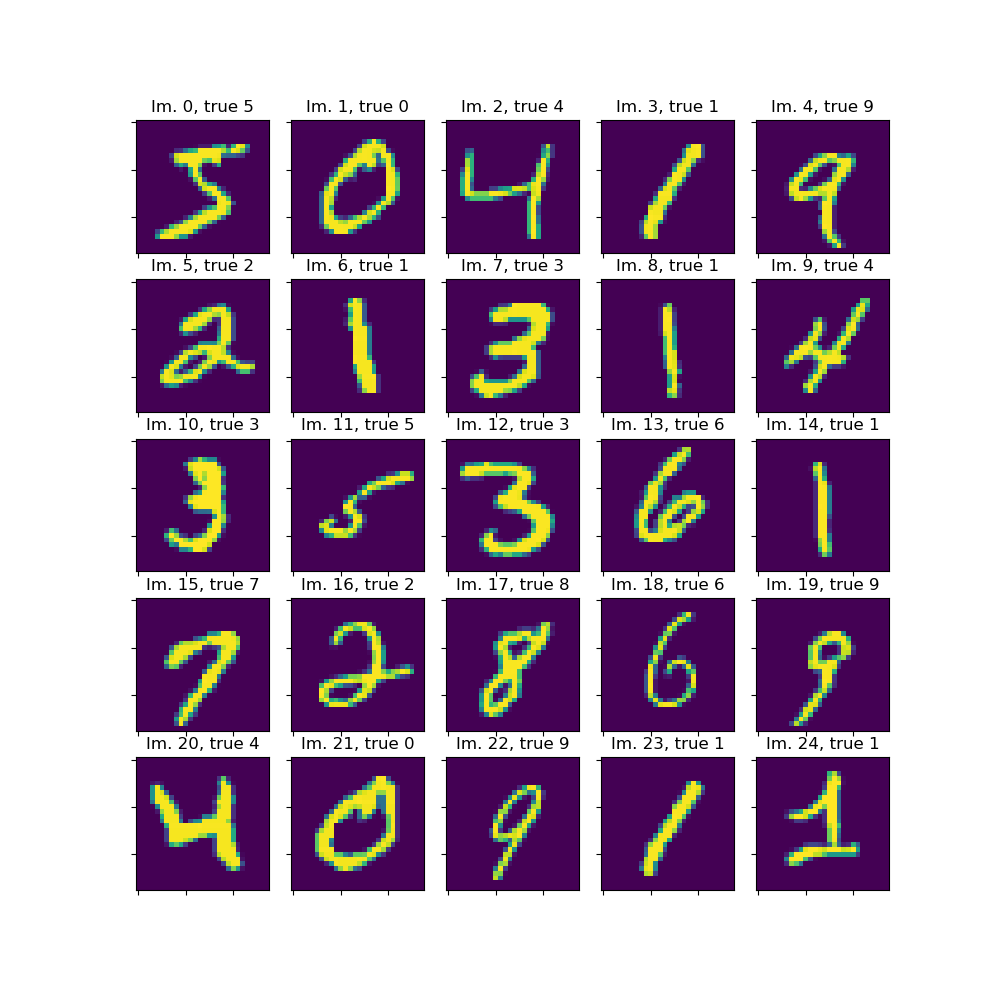

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        idx = i*5+j
        img = my_dataset[idx][0]
        label = my_dataset[idx][1]
        ax[i, j].imshow(img[0,...].detach().cpu().numpy())
        ax[i, j].set(title=f"Im. {idx}, true {label}")
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
plt.subplots_adjust(hspace=0.2,wspace=0)
plt.show()

And now let us define the neural network. In PyTorch, neural networks always extend `nn.Module`. They define their sub-parts in their constructor, which are convolutional layers and fully connected linear layers in this case, and the method `forward` is expected to receive an input image and output the network target.

The network parameters are the weights of the `Conv2d` and `Linear` layers, which are conveniently hidden here, but can be accessed if you try to access their `weights` elements.

We will not directly output the label probabilities, since we do not actually need it to optimize the neural network: we need only the logits.

In [8]:
class Network(nn.Module):
    """
        This is our parametrized function.
        It stores all the parametrized weights theta inside the conv1, conv2, fc1 and fc2 objects.
        The forward function receives an image and outputs a vector.
        
        The intuition is that the i-th component of the vector represents the probability that
        the probability that the image belongs to the i-th class however
        we do not normalize the output to be in the range [0,1] and to sum to 1. The reason is
        that this normalization is done later, in the training step, where the numerical error in it can be
        minimized by calculating directly log(probability) instead of calculating first the probability
        and then the log of it. Keep in mind therefore, that to get probabilities
        from this object one should do F.softmax(my_network(x), dim=1).
        
        The code has been written like this, as this is a common optimization done in classification problems.
    """
    def __init__(self):
        """
        Constructor. Here we initialize the weights.
        """
        super().__init__()

        # define parameters
        
        # all these steps are purely linear (affine if one considers the bias)
        # the forward function adds a non-linearity through the ReLU to allow this to do more than
        # simple linear filters
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, x):
        """
        This function is called when one does my_network(x) and it represents the action
        of our parametrized function in the image, outputting the probabilities for that image as
        a column vector. The input x has shape (B, C, H, W) (ie: batch dimension, channels, height and width).
        The output has shape (B, K), where K is the number of classes.
        Each row of the output has the probability for each class as a column vector.
        Each column of the output has the probability for a single class for all images B given as an input.
        """

        # first convolution
        t = self.conv1(x)
        # non-linearity
        t = F.relu(t)
        # reduce size of the image in width and height by taking the maximum
        # pixel value in each 2x2 pixel matrix (kernel_size) and skipping one pixel (stride)
        # the convolution receives one channel and outputs more
        # the goal of the max_pool layer is to reduce the image size, so we
        # can get more images in several channels which are smaller in size
        # this is a trade off between memory and compute
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # second convolution
        t = self.conv2(t)
        # non-linearity
        t = F.relu(t)
        # reduce the size of the image in width and height again
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # transform images into a single vector using reshape
        # this puts all pixel values in a single vector
        t = t.reshape(-1, 12*4*4)
        
        # apply a linear transformation
        t = self.fc1(t)
        # add a non-linearity
        t = F.relu(t)

        # another linear transformation
        t = self.fc2(t)
        # another non-linearity
        t = F.relu(t)

        # final linear transformation
        # the output of this has been set to 10 features, so the output will have the size
        # (B, 10)
        t = self.out(t)

        # note: while we want the function to output a probability,
        # we do not actually do any effort to normalize these numbers so that they are in [0, 1]
        # and so that their sum is 1
        # this would often be done by applying a transformation called Softmax(t) = exp(t)/sum(exp(t))
        # however, this will be done internally by PyTorch in the function F.cross_entropy
        # which we will call later on when training

        return t

Let us create one instance of this network. We also create an instance of PyTorch's `DataLoader`, which has the task of taking a given number of data elements and outputing it in a single object. This "mini-batch" of data is used during training, so that we do not need to load the entire data in memory during the optimization procedure.

We also create an instance of the Adam optimizer, which is used to tune the parameters of the network.

In [9]:
network = Network()
B = 64
loader = torch.utils.data.DataLoader(my_dataset, batch_size=B)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

Now we actually repeatedly try to optimize the network parameters. Each time we go through all the data we have, we go through one "epoch". For each epoch, we take several "mini-batches" of data (given by the `DataLoader` in `loader`) and use it to make one training step.

In [10]:
epochs = 10
# for each epoch
for epoch in range(epochs):
    losses = list()
    # for each mini-batch given by the loader:
    for batch in loader:
        # get the images in the mini-batch
        # this has size (B, C, H, W)
        # where B is the mini-batch size
        # C is the number of channels in the image (1 for grayscale)
        # H is the height of the image
        # W is the width of the image
        images = batch[0]
        # get the labels in the mini-batch (there shall be B of them)
        labels = batch[1]
        # get the output of the neural network:
        logits = network(images)
        
        # note: the network does not output probabilities directly: it outputs logits
        # to get probabilities from it we would need to do F.softmax(logits, dim=1)
        # however, this is done inside F.cross_entropy below and we therefore should
        # not do it twice here
        # the reason it is done internally, in F.cross_entropy, is that what we really
        # need is log(probability) and we can reduce the numerical error
        # in its calculation by calculating log(softmax(.)) in one go
        # (remember softmax(x) = exp(x)/sum(exp(x)), so log(softmax(x)) = x - log(sum(exp(x))))
        
        # calculate the loss function being minimized
        # in this case, it is the cross-entropy between the logits and the true labels
        loss = F.cross_entropy(logits, labels)

        # clean the optimizer temporary gradient storage
        optimizer.zero_grad()
        # calculate the gradient of the loss function as a function of the gradients
        loss.backward()
        # ask the Adam optimizer to change the parameters in the direction of - gradient
        # Adam scales the gradient by a constant which is adaptively tuned
        # take a look at the Adam paper for more details: https://arxiv.org/abs/1412.6980
        optimizer.step()
        losses.append(loss.detach().cpu().item())
    avg_loss = np.mean(np.array(losses))
    print(f"Epoch {epoch}/{epochs}: average loss {avg_loss:.5f}")

Epoch 0/10: average loss 0.36806
Epoch 1/10: average loss 0.11563
Epoch 2/10: average loss 0.07839
Epoch 3/10: average loss 0.05962
Epoch 4/10: average loss 0.04747
Epoch 5/10: average loss 0.03930
Epoch 6/10: average loss 0.03396
Epoch 7/10: average loss 0.02854
Epoch 8/10: average loss 0.02372
Epoch 9/10: average loss 0.02109


Let us check what the network says about some new data it has never seen before (note that we set `train` to `False`, to take a statistically independent part of the dataset).

In [11]:
test_dataset = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

And now we can plot again the new images, now showing what the network tells us about it.

<IPython.core.display.Javascript object>


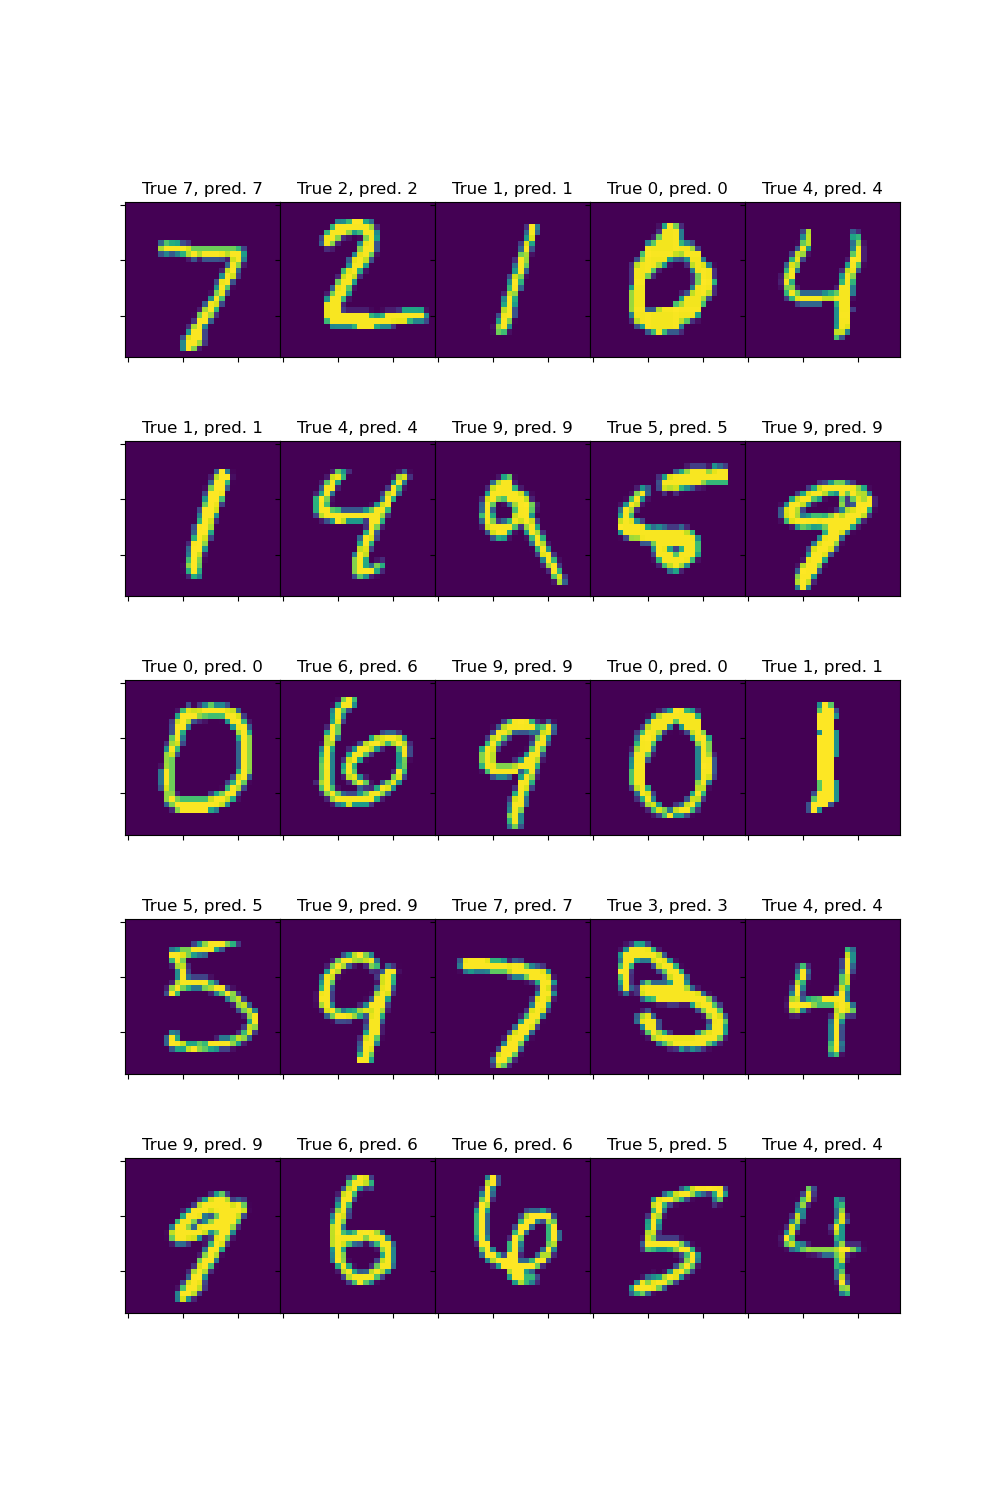

In [12]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,15))
for i in range(5):
    for j in range(5):
        idx = i*5+j
        img = test_dataset[idx][0]
        label = test_dataset[idx][1]
        logits = network(img[None, ...]) # output
        probs = F.softmax(logits, dim=1) # apply softmax to normalize them
        predicted = torch.argmax(probs[0, ...]) # index of the highest probability
        ax[i, j].imshow(img[0,...].detach().cpu().numpy())
        ax[i, j].set(title=f"True {label}, pred. {predicted}")
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
plt.subplots_adjust(hspace=0.2,wspace=0)
plt.show()

We can also examine the probability that the network gives for all images in the expected class. That is: what is the predicted probability of the network for all images in the true class 4?

In [13]:
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=32)
logits = list()
label = list()
for batch in test_loader:
    logits += [network(batch[0])]
    label += [batch[1]]
logits = torch.cat(logits, dim=0)
label = torch.cat(label, dim=0)
probs = F.softmax(logits, dim=1)

In [14]:
probs_4 = probs.detach().cpu().numpy()[label.detach().cpu().numpy() == 4]

We can histogram it and see that it did mostly a good job, but sometimes it failed. We can go forward and make a cut in the probability and look at those images to identify which images were incorrectly classified.

<IPython.core.display.Javascript object>


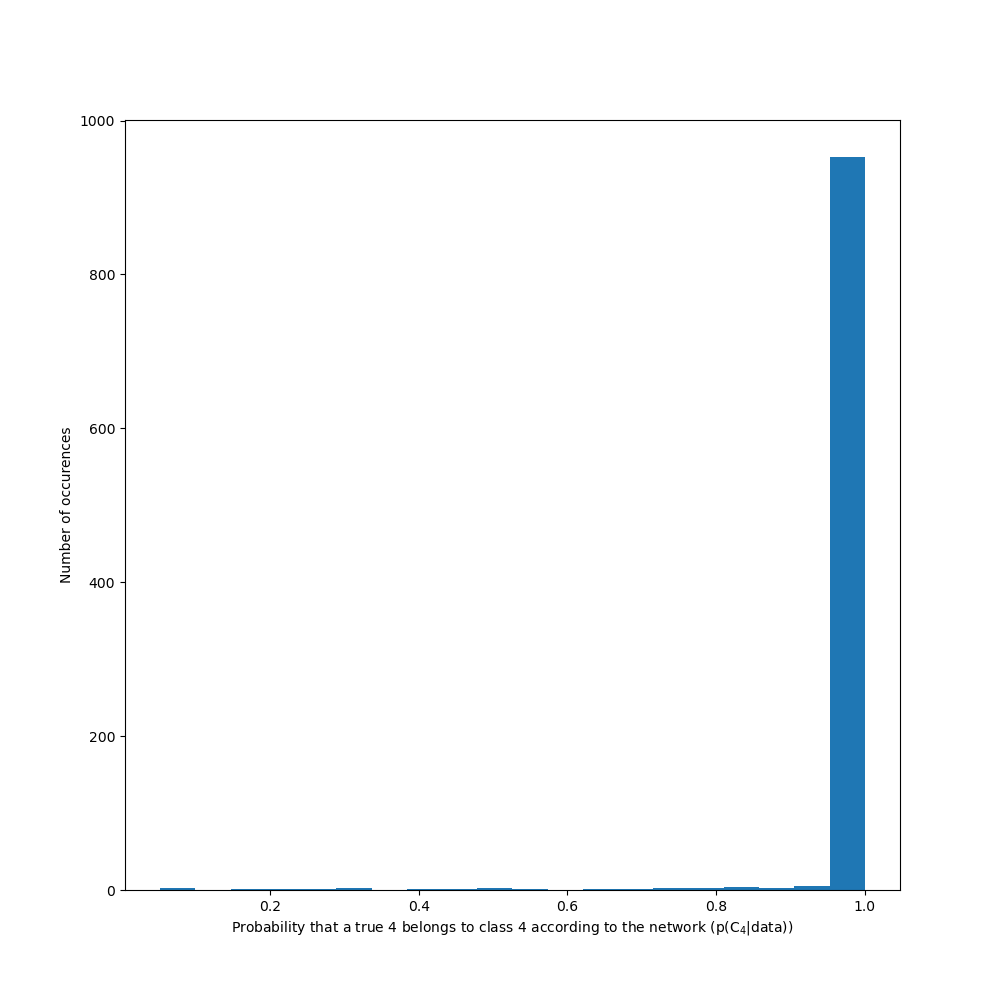

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(probs_4[:, 4], bins=20)
ax.set(xlabel=r"Probability that a true 4 belongs to class 4 according to the network (p(C$_4$|data))",
       ylabel="Number of occurences",
       title="")
plt.show()

### Contact us at the EuXFEL Data Analysis group at any time if you need help analysing your data!

#### Data Analysis group: da@xfel.eu